# Instalaciones de paquetes requeridos

- LIWC: se usa este paquete para poder cargar el diccionario provisto en el directorio ```data```

In [63]:
#%pip install liwc

In [64]:
#!python -m spacy download es_core_news_sm
#nltk.download('punkt')
#nltk.download('stopwords')

In [83]:
import string
import warnings
from collections import Counter
from itertools import compress
import pandas as pd
import spacy
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

import liwc
parse, category_names = liwc.load_token_parser('data/dict_r.dic')

In [66]:
nlp = spacy.load('es_core_news_sm')

In [67]:
institutions = pd.read_excel('data/ELA - Instituciones.xlsx')

# Preprocesamiento

Este proceso se realiza con el fin de poder modificar o eliminar algunos componentes dentro de los corpus de texto:
- convierte todos los corpus a minuscula
- elimina signos de punctuacion
- elimina espacios en blanco dentro del corpus
- elimina posibles saltos de línea
- selecciona solo corpus que tienen más de una palabra

In [68]:
def preprocess(df, concept = None, all_less_concept = None):
  institutions = df
  if concept is not None:
    institutions = institutions[institutions["categoria"] == concept]

  if all_less_concept is not None:
    institutions = institutions[institutions["categoria"] != all_less_concept]

  institutions['fundamento'] = institutions['fundamento'].str.lower()
  institutions['fundamento'] = institutions['fundamento'].str.translate(str.maketrans(' ', ' ', string.punctuation))
  institutions['fundamento'] = institutions['fundamento'].str.strip()
  institutions['fundamento'] = institutions['fundamento'].str.replace('\n', ' ')

  institutions = institutions[[len(str(x).split()) > 2 for x in institutions.fundamento]]
  return institutions.reset_index(drop=True)

# Eleccion de concepto target

Se elige el concepto de **Fuerzas Armadas** como concepto target para trabajar en el procesamiento, para ser cargado dentro del dataframe ```institutions_ffaa```

In [69]:
institutions_ffaa = preprocess(institutions, "Fuerzas Armadas")

# Carga y preprocesamiento de todos los conceptos, menos el concepto target

Se cargan todos los conceptos, menos el concepto target (en este caso **Fuerzas Armadas**) para ser cargados en el dataframe ```institutions_less_ffaa```

In [70]:
institutions_less_ffaa = preprocess(institutions, all_less_concept = "Fuerzas Armadas")

# Carga y preprocesamiento de todos los conceptos

Se cargan todos los conceptos, incluido el concepto target (en este caso **Fuerzas Armadas**) para ser cargados en el dataframe ```institutions_all```

In [71]:
institutions_all = preprocess(institutions)

### 1 - Construccion de diccionario

Se construye el diccionario con el concepto target **Fuerzas Armadas** para parear las palabras de los corpus, con termino del diccionario cargado en ```data/dict_r.dic```.
Por cada corpus se cuenta la cantidad de veces que se repite el termino del diccionario.

In [72]:
df = pd.DataFrame()
l_derechos = []

for ix in range(institutions_ffaa.shape[0]):
  texto = str(institutions_ffaa.fundamento[ix]).lower()
  doc = nlp(texto)
  tokens = [word.orth_ for word in doc]
  tcounts1 = Counter(category for token in tokens for category in parse(token))
  word_derechos = list(compress(tokens, ['derechos' in parse(token) for token in tokens]))
  df_counts = pd.DataFrame.from_dict([tcounts1]).reset_index()
  df_counts['index'] = ix
  df_counts['texto'] = texto
  df_counts['word_derechos'] =  ['' if len(word_derechos) == 0 else word_derechos]
  df = pd.concat([df,df_counts], axis=0, ignore_index=True)

  if len(word_derechos)>0:
        l_derechos.extend(word_derechos)

df_concept_ffaa = pd.DataFrame.from_dict(Counter(l_derechos), orient = 'index').reset_index()
df_concept_ffaa = df_concept_ffaa.rename(columns = {'index' : 'termino', 0 : 'count'})
df_concept_ffaa.sort_values('count', ascending = False)[0:20]

,termino,count
0,proteger,73
2,defender,58
9,respetar,25
8,cumplir,21
13,decir,15
7,ejercer,13
5,contribuir,12
3,responder,9
11,trabajar,5
12,procurar,5


### 2 (1) - Verificacion/Validacion diccionario

### Diccionario original

Se dejan los terminos cargados en el diccionario ```dict_r.dic``` y pareados con cada corpus del concepto **Fuerzas Armadas**. Con esto se obtiene la cantidad (ordenada de mayor a menor) de veces en que estos aparecen dentro de cada corpus procesado con el concepto target **Fuerzas Armadas**

In [73]:
df_concept_ffaa.sort_values(by = ["count"], ascending = False)

,termino,count
0,proteger,73
2,defender,58
9,respetar,25
8,cumplir,21
13,decir,15
7,ejercer,13
5,contribuir,12
3,responder,9
11,trabajar,5
12,procurar,5


### 3 (1) - Desempeño diccionario

De los terminos propuestos en el procesamiento del punto **2 (1) - Verificacion/Validacion diccionario**, se genera una matriz de verificacion por todos los conceptos de la base de datos ```ELA - Instituciones.xlsx```. Todos los conceptos seran sumados al indicador, de acuerdo a cuantas veces se repita dicho término del diccionario, dentro de la frase de cada concepto dentro de la base ```ELA - Instituciones.xlsx```

In [74]:
df_dummy_categories_ffaa = pd.get_dummies(df_concept_ffaa.groupby(by = ['termino']).count().reset_index()['termino'])
df_dummy_categories_ffaa = df_dummy_categories_ffaa[0:0]
df_institutions_all_group = institutions_all.groupby(by = ['categoria']).count().reset_index()['categoria']
df_dummy_categories_ffaa['categoria'] = df_institutions_all_group

df_dummy_categories_ffaa = df_dummy_categories_ffaa.set_index("categoria")

for col in df_dummy_categories_ffaa.columns:
    df_dummy_categories_ffaa[col].values[:] = 0

for index, row in institutions_all.iterrows():
  for i, v in df_dummy_categories_ffaa.loc[row['categoria']].items():
    df_dummy_categories_ffaa.loc[row['categoria']][i] = df_dummy_categories_ffaa.loc[row['categoria']][i] + row['fundamento'].count(i)

In [75]:
df_dummy_categories_ffaa['suma'] = \
  df_dummy_categories_ffaa['apoyar'] + \
  df_dummy_categories_ffaa['conocer'] + \
  df_dummy_categories_ffaa['conservar'] + \
  df_dummy_categories_ffaa['contribuir'] + \
  df_dummy_categories_ffaa['cumplir'] + \
  df_dummy_categories_ffaa['decir'] + \
  df_dummy_categories_ffaa['defender'] + \
  df_dummy_categories_ffaa['educar'] + \
  df_dummy_categories_ffaa['ejercer'] + \
  df_dummy_categories_ffaa['guardar'] + \
  df_dummy_categories_ffaa['procurar'] + \
  df_dummy_categories_ffaa['proteger'] + \
  df_dummy_categories_ffaa['respetar'] + \
  df_dummy_categories_ffaa['responder'] + \
  df_dummy_categories_ffaa['servir'] + \
  df_dummy_categories_ffaa['tomar'] + \
  df_dummy_categories_ffaa['trabajar'] + \
  df_dummy_categories_ffaa['usar'] + \
  df_dummy_categories_ffaa['vivir']

df_dummy_categories_ffaa.sort_values(by = ['suma'], ascending = False)

,apoyar,conocer,conservar,contribuir,cumplir,decir,defender,educar,ejercer,guardar,procurar,proteger,respetar,responder,servir,tomar,trabajar,usar,vivir,suma
categoria,,,,,,,,,,,,,,,,,,,,
Defensor del Pueblo / Ciudadano,10.0,10.0,1.0,2.0,16.0,4.0,307.0,1.0,26.0,42.0,3.0,112.0,10.0,5.0,3.0,13.0,4.0,2.0,2.0,573.0
"Plebiscitos, referendos y consultas",6.0,58.0,1.0,3.0,9.0,14.0,5.0,7.0,76.0,14.0,0.0,3.0,13.0,5.0,6.0,155.0,1.0,15.0,12.0,403.0
Fuerzas Armadas,6.0,6.0,1.0,12.0,22.0,15.0,64.0,1.0,13.0,90.0,5.0,77.0,27.0,10.0,4.0,4.0,5.0,10.0,2.0,374.0
Poder judicial (estructura y funciones),0.0,19.0,2.0,1.0,91.0,6.0,6.0,2.0,28.0,22.0,2.0,14.0,16.0,4.0,1.0,6.0,7.0,3.0,2.0,232.0
Congreso o parlamento,2.0,10.0,5.0,0.0,33.0,11.0,2.0,0.0,21.0,33.0,1.0,5.0,7.0,5.0,10.0,15.0,19.0,3.0,5.0,187.0
Gobierno regional,9.0,13.0,4.0,6.0,10.0,4.0,2.0,0.0,8.0,6.0,1.0,1.0,1.0,3.0,0.0,49.0,9.0,3.0,5.0,134.0
Gobierno nacional (estructura y funciones),2.0,10.0,0.0,2.0,18.0,3.0,10.0,3.0,11.0,10.0,1.0,20.0,12.0,2.0,2.0,6.0,9.0,1.0,10.0,132.0
Gobierno local / Municipal,12.0,17.0,1.0,5.0,5.0,3.0,1.0,0.0,10.0,5.0,2.0,4.0,3.0,8.0,0.0,29.0,19.0,0.0,5.0,129.0
Presidencia de la República,3.0,10.0,3.0,0.0,29.0,3.0,6.0,1.0,10.0,12.0,1.0,4.0,19.0,1.0,0.0,4.0,4.0,1.0,1.0,112.0


_______________________________

### 2 (2) - Diccionario luego del procesamiento del punto 3 (Desempeño diccionario)
Luego del proceso del punto 3, se sacan los terminos:
- guardar
- responder
- tomar
- usar

In [76]:
df_concept_ffaa_ = df_concept_ffaa
df_concept_ffaa_ = df_concept_ffaa_.drop(df_concept_ffaa_[df_concept_ffaa_["termino"] == "vivir"].index)
df_concept_ffaa_ = df_concept_ffaa_.drop(df_concept_ffaa_[df_concept_ffaa_["termino"] == "educar"].index)
df_concept_ffaa_ = df_concept_ffaa_.drop(df_concept_ffaa_[df_concept_ffaa_["termino"] == "guardar"].index)
df_concept_ffaa_ = df_concept_ffaa_.drop(df_concept_ffaa_[df_concept_ffaa_["termino"] == "conservar"].index)

df_concept_ffaa_.sort_values(by = ["count"], ascending = False)

,termino,count
0,proteger,73
2,defender,58
9,respetar,25
8,cumplir,21
13,decir,15
7,ejercer,13
5,contribuir,12
3,responder,9
11,trabajar,5
12,procurar,5


### 3 (2) - Desempeño diccionario (con diccionario sin algunos terminos)

De los terminos propuestos en el procesamiento del punto 2 (2) - Verificacion/Validacion diccionario, se genera una matriz de verificacion por todos los conceptos de la base de datos ```ELA - Instituciones.xlsx```, con la salvedad de eliminacion de terminos como **guardar**, **responder**, **tomar**, **usar**. Estos terminos son eliminados del procesamiento, tomando el significado bajo juicio experto, para poder tener terminos más acordes a . Todos los conceptos seran sumados al indicador, de acuerdo a cuantas veces se repita dicho termino del diccionario, dentro de la frase de cada concepto dentro de la base ```ELA - Instituciones.xlsx```

In [77]:
df_dummy_categories_ffaa_ = pd.get_dummies(df_concept_ffaa_.groupby(by = ['termino']).count().reset_index()['termino'])
df_dummy_categories_ffaa_ = df_dummy_categories_ffaa_[0:0]
df_institutions_all_group_ = institutions_all.groupby(by = ['categoria']).count().reset_index()['categoria']
df_dummy_categories_ffaa_['categoria'] = df_institutions_all_group_

df_dummy_categories_ffaa_ = df_dummy_categories_ffaa_.set_index("categoria")

for col in df_dummy_categories_ffaa_.columns:
    df_dummy_categories_ffaa_[col].values[:] = 0

for index, row in institutions_all.iterrows():
  for i, v in df_dummy_categories_ffaa_.loc[row['categoria']].items():
    df_dummy_categories_ffaa_.loc[row['categoria']][i] = df_dummy_categories_ffaa_.loc[row['categoria']][i] + row['fundamento'].count(i)

In [78]:
df_dummy_categories_ffaa_['suma'] = \
  df_dummy_categories_ffaa_['apoyar'] + \
  df_dummy_categories_ffaa_['conocer'] + \
  df_dummy_categories_ffaa_['contribuir'] + \
  df_dummy_categories_ffaa_['cumplir'] + \
  df_dummy_categories_ffaa_['decir'] + \
  df_dummy_categories_ffaa_['defender'] + \
  df_dummy_categories_ffaa_['ejercer'] + \
  df_dummy_categories_ffaa_['procurar'] + \
  df_dummy_categories_ffaa_['proteger'] + \
  df_dummy_categories_ffaa_['respetar'] + \
  df_dummy_categories_ffaa_['responder'] + \
  df_dummy_categories_ffaa_['servir'] + \
  df_dummy_categories_ffaa_['tomar'] + \
  df_dummy_categories_ffaa_['trabajar'] + \
  df_dummy_categories_ffaa_['usar']

df_dummy_categories_ffaa_.sort_values(by = ['suma'], ascending = False)

,apoyar,conocer,contribuir,cumplir,decir,defender,ejercer,procurar,proteger,respetar,responder,servir,tomar,trabajar,usar,suma
categoria,,,,,,,,,,,,,,,,
Defensor del Pueblo / Ciudadano,10.0,10.0,2.0,16.0,4.0,307.0,26.0,3.0,112.0,10.0,5.0,3.0,13.0,4.0,2.0,527.0
"Plebiscitos, referendos y consultas",6.0,58.0,3.0,9.0,14.0,5.0,76.0,0.0,3.0,13.0,5.0,6.0,155.0,1.0,15.0,369.0
Fuerzas Armadas,6.0,6.0,12.0,22.0,15.0,64.0,13.0,5.0,77.0,27.0,10.0,4.0,4.0,5.0,10.0,280.0
Poder judicial (estructura y funciones),0.0,19.0,1.0,91.0,6.0,6.0,28.0,2.0,14.0,16.0,4.0,1.0,6.0,7.0,3.0,204.0
Congreso o parlamento,2.0,10.0,0.0,33.0,11.0,2.0,21.0,1.0,5.0,7.0,5.0,10.0,15.0,19.0,3.0,144.0
Gobierno regional,9.0,13.0,6.0,10.0,4.0,2.0,8.0,1.0,1.0,1.0,3.0,0.0,49.0,9.0,3.0,119.0
Gobierno local / Municipal,12.0,17.0,5.0,5.0,3.0,1.0,10.0,2.0,4.0,3.0,8.0,0.0,29.0,19.0,0.0,118.0
Gobierno nacional (estructura y funciones),2.0,10.0,2.0,18.0,3.0,10.0,11.0,1.0,20.0,12.0,2.0,2.0,6.0,9.0,1.0,109.0
Forma de Estado,1.0,22.0,3.0,2.0,3.0,0.0,4.0,1.0,2.0,8.0,4.0,1.0,49.0,3.0,1.0,104.0


_______________________________________________

# Conclusiones

Se genera un nuevo dataframe para poder evaluar la prevalencia de los conceptos con los terminos del diccionario orinales (20 en total) y con los terminos eliminados del diccionario correspondientes a **guardar**, **responder**, **tomar**, **usar** (16 resultantes).


### Cambios entre las dos evaluaciones

La primera conclusion a la que se puede llegar, es a que hay una diferencia al comparar el concepto target correspondiente a **Fuerzas Armadas** la cual refleja **94** apariciones menos de los terminos eliminados del diccionario, con los que se evaluan en un inicio.

El segundo concepto con más diferencia es **Defensor del Pueblo / Ciudadano** con una diferencia de **46** apariciones menos con respecto a la evaluacion inicial. Esto puede verse correlacionado con el término target **Fuerzas Armadas**, debido a su naturaleza de defensa, nivel de respuesta en emergencias, toma de decisiones (que pueden tomar respecto del civil).

El tercer concepto con más diferencia es **Congreso o parlamento** con una diferencia de **43** apariciones menos con respecto a la evaluacion inicial. Esto puede verse correlacionado con el término target **Fuerzas Armadas**, debido a las decisiones que pueden tomar estas dentro del ambito civil.


### Sin cambios entre las evaluaciones

Luego de eliminados los terminos **guardar**, **responder**, **tomar**, **usar** del diccionario, hubo algunos conceptos que no sufrieron cambios entre el procesamiento original y el procesamiento sin dichos terminos. Los conceptos sin cambios son:

- **Iniciativa popular de Ley**
- **Tribunal de Defensa de la Libre Competencia**
- **Autonomía regional**
- **Eliminacion de Tribunal Constitucional**
- **Servicio Nacional de Asuntos Religiosos**

In [92]:
df_compare = pd.DataFrame({
  'suma_original': df_dummy_categories_ffaa['suma'],
  'suma_sin_conceptos': df_dummy_categories_ffaa_['suma'],
  'diferencia': df_dummy_categories_ffaa['suma'] - df_dummy_categories_ffaa_['suma'],
}).sort_values(by = ['suma_original', 'suma_sin_conceptos'], ascending = False)

df_compare

,suma_original,suma_sin_conceptos,diferencia
categoria,,,
Defensor del Pueblo / Ciudadano,573.0,527.0,46.0
"Plebiscitos, referendos y consultas",403.0,369.0,34.0
Fuerzas Armadas,374.0,280.0,94.0
Poder judicial (estructura y funciones),232.0,204.0,28.0
Congreso o parlamento,187.0,144.0,43.0
Gobierno regional,134.0,119.0,15.0
Gobierno nacional (estructura y funciones),132.0,109.0,23.0
Gobierno local / Municipal,129.0,118.0,11.0
Presidencia de la República,112.0,95.0,17.0


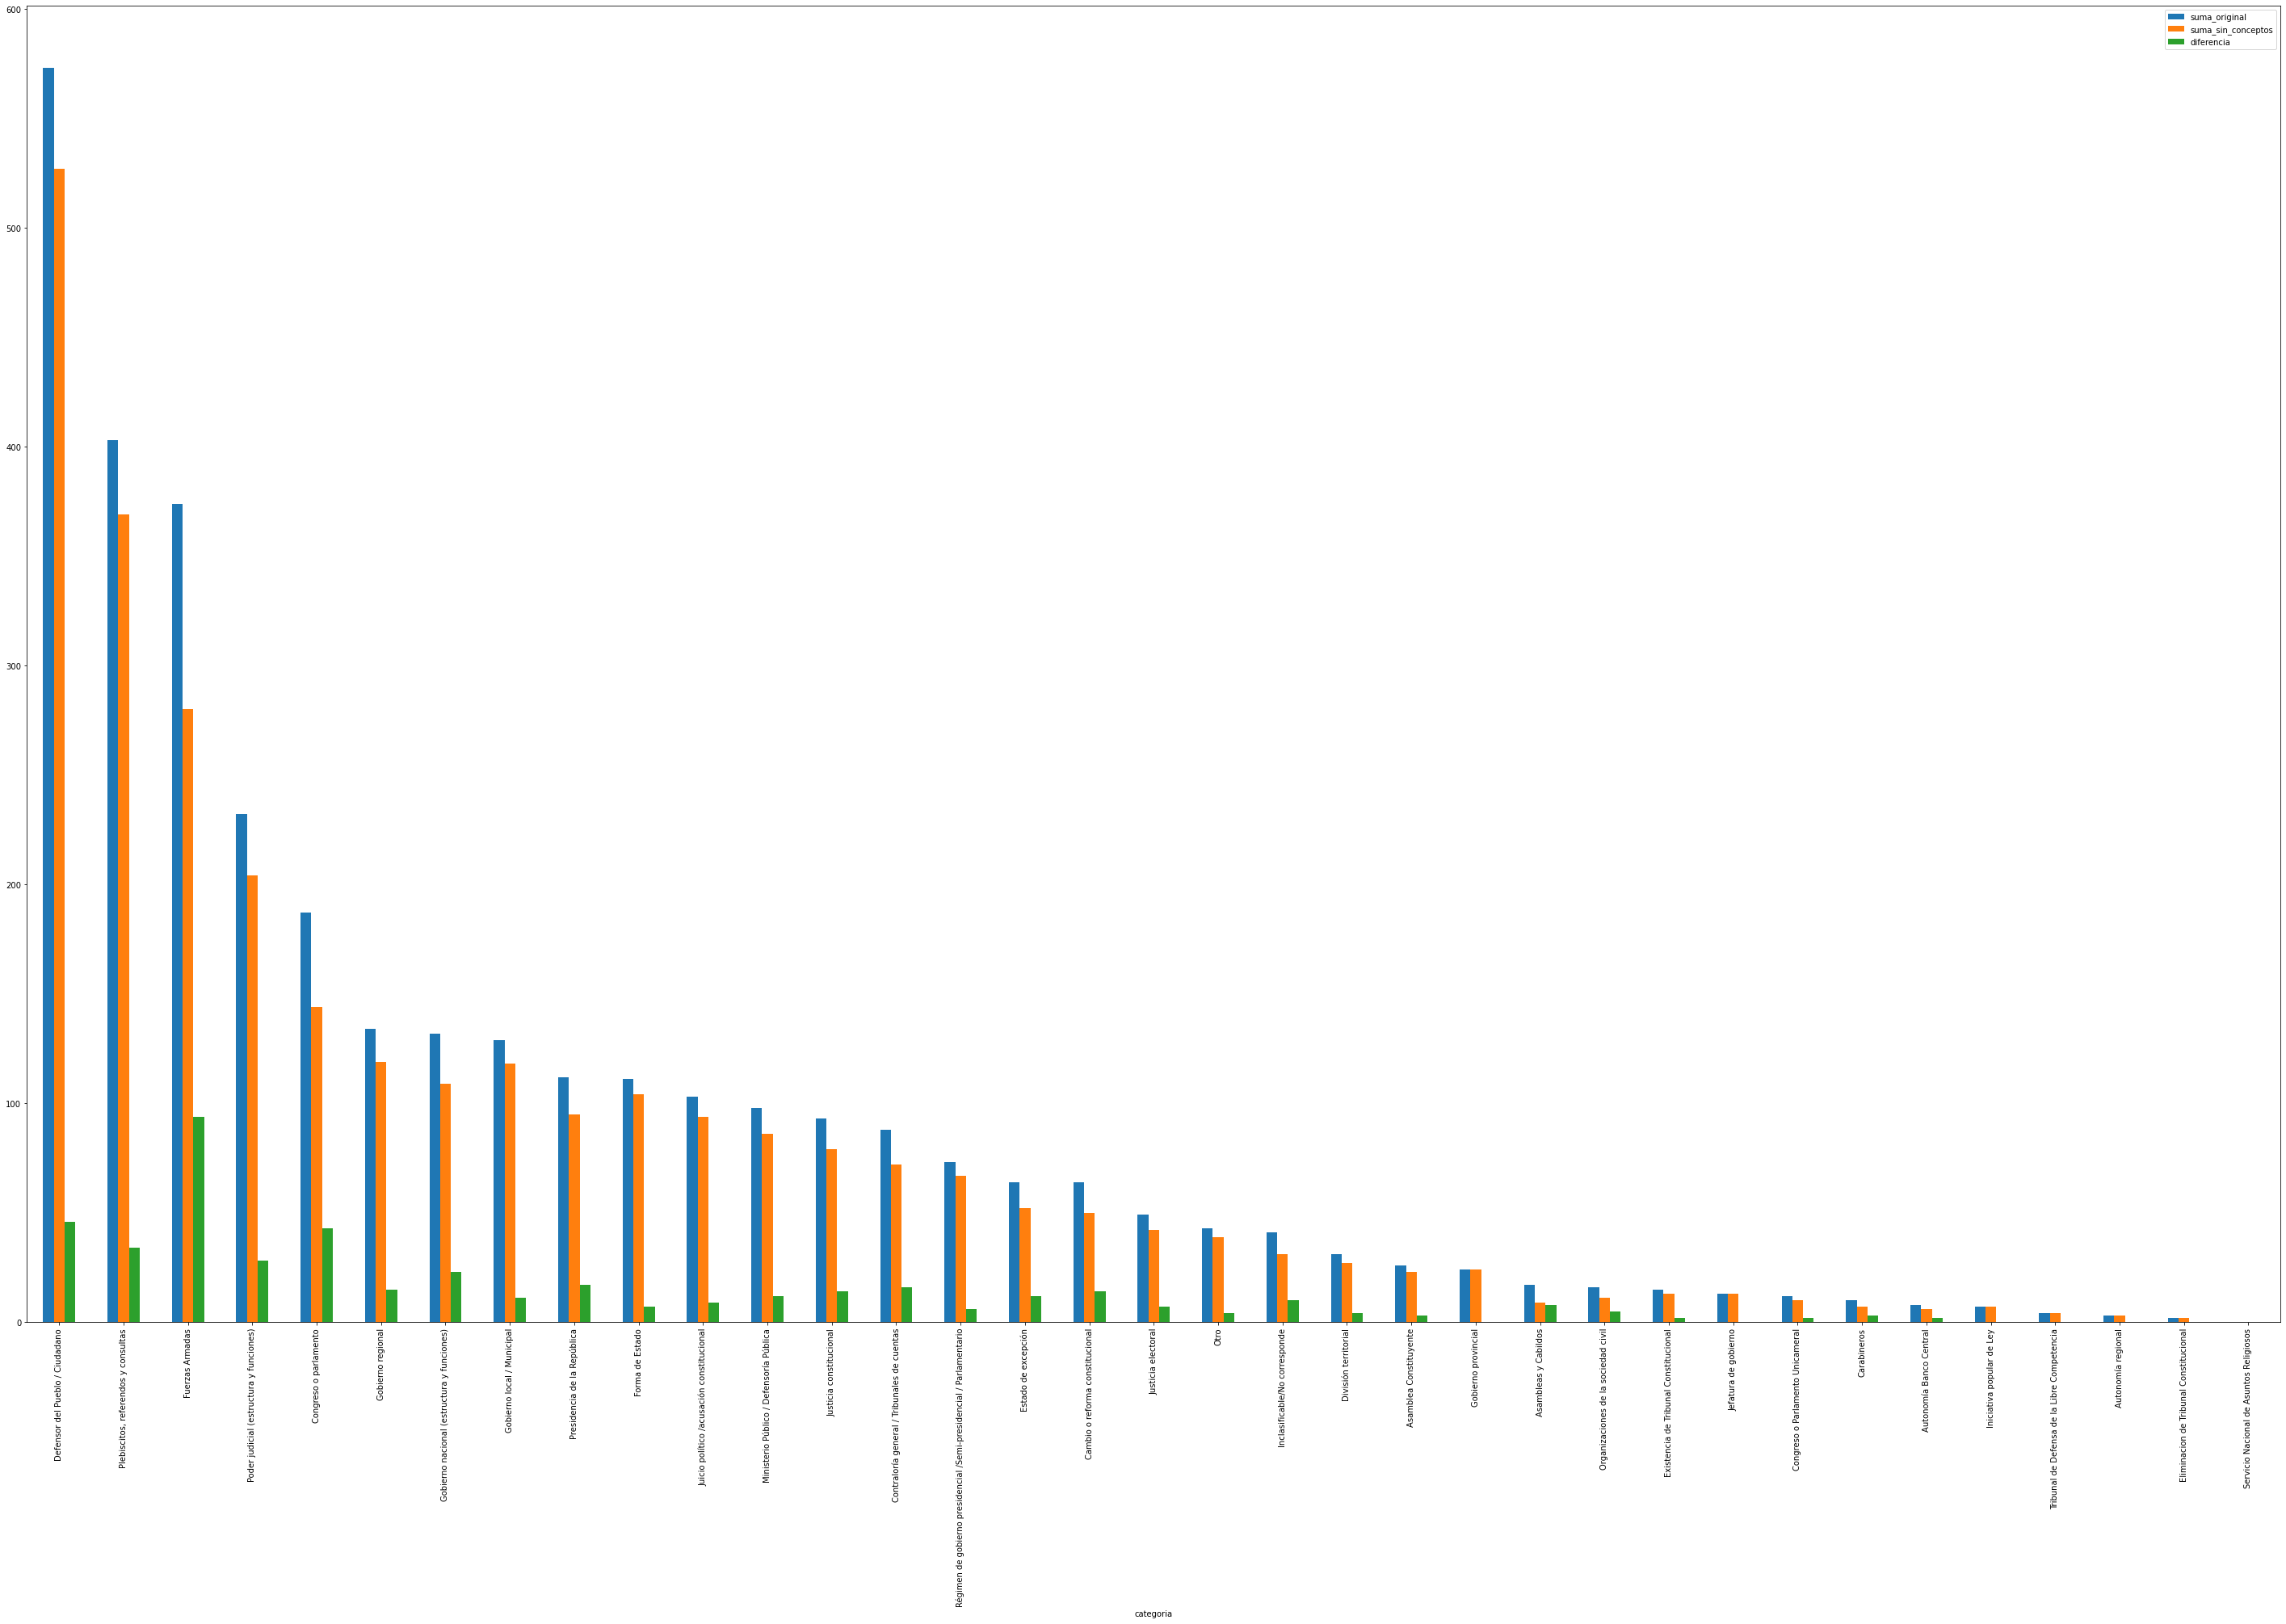

In [94]:
df_compare.plot.bar(figsize=(50,30))
plt.show()